In [1]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform
from scipy.spatial import KDTree
from sympy import flatten

import seaborn as sns

from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4566 rows x 9 columns]
Data shape:  (4566, 3)
Star ID (HIP):  

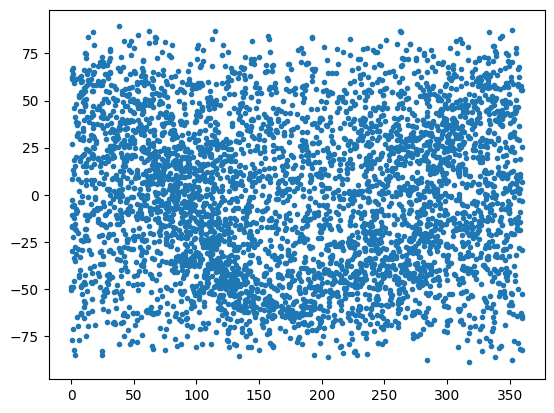

In [2]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID (HIP): ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [43]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []
features_1_n = []
features_2_n = []



feature_type_1 = 'permutation_angle_dist'
feature_type_2 = 'permutation'

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        
    features_1 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_1)
    features_2 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_2)

    features_vec_1.append(features_1)
    features_vec_2.append(features_2)


features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min(axis = 0)) / (star_features.max(axis = 0) - star_features.min(axis = 0))
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

print("Features 1 shape: ", features_1_n.shape)
print("Features 2 shape: ", features_2_n.shape)

# Print example of the features
print("Example of the features: ")
print("Features 1: ", features_vec_1[0])
print("Features 2: ", features_vec_2[0])

Features 1 shape:  (4566, 10)
Features 2 shape:  (4566, 10)
Example of the features: 
Features 1:  [ 1.2681326  19.84727981  0.72330027  0.41477326  2.35175967  7.1793706
  7.42159486  3.56359993  3.24396789  3.31588988]
Features 2:  [0.26403315 3.61403621 4.33014412 4.7264928  3.41432565 4.35828078
 4.73312743 3.71788338 3.68960193 0.53448458]


In [40]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
stars_cordinates = stars_data[:,1:3]

tree = KDTree(stars_cordinates)

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_cordinates, k=n_of_neighbor+1)

#Initialice the dual SOM features vector
distances = []
angles = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):

    # Initialice the subsets of features
    distance = []
    angle = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        distance.append(np.linalg.norm(stars_cordinates[i] - stars_cordinates[neighbor_index]))
        angle.append(np.arctan2(stars_cordinates[i][1] - stars_cordinates[neighbor_index][1], stars_cordinates[i][0] - stars_cordinates[neighbor_index][0]) )

    distances.append(distance)
    angles.append(angle)

distances = np.array(distances)
angles = np.array(angles)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min()) / (star_features.max() - star_features.min())
    return star_features_normalized

distances_normalized = normalize_features(distances)
angles_normalized = normalize_features(angles)

print("distances shape: ", distances.shape)
print("angles shape: ", angles.shape)

# Print example of the features
print("Example of the features: ")
print("distances 1: ", distances[0])
print("angles 2: ", angles[0])

distances shape:  (4566, 4)
angles shape:  (4566, 4)
Example of the features: 
distances 1:  [0.26403315 3.61403621 4.33014412 4.7264928 ]
angles 2:  [-1.66133685 -2.35012869  2.97455427  3.05383768]


## Data visualization 

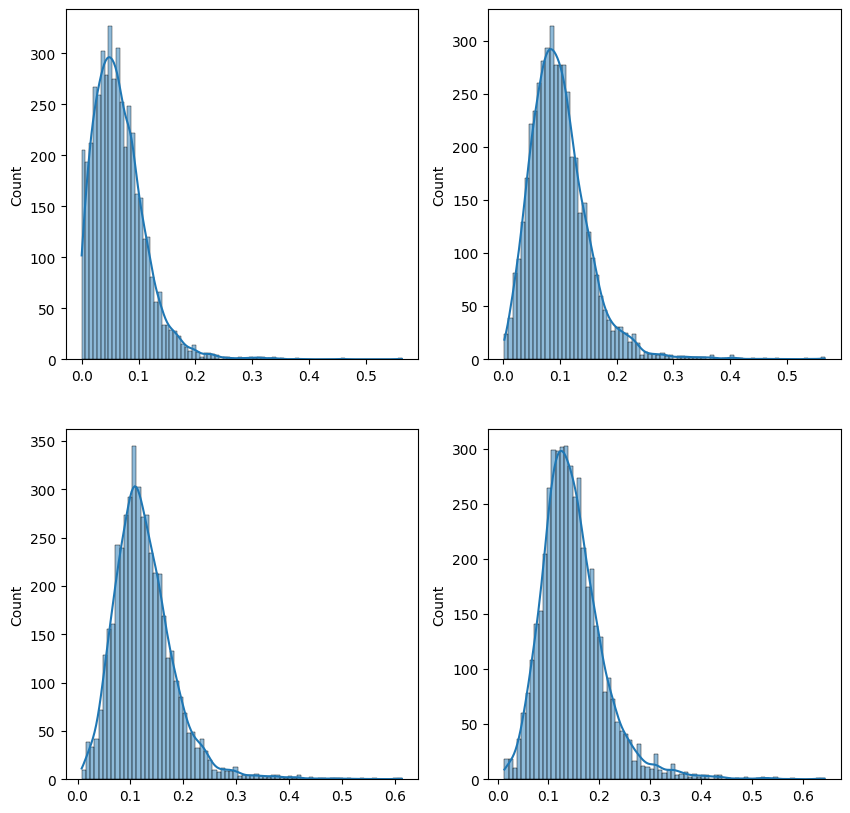

In [5]:
# Plot the probability distribution of the features_2_n[:, 0:6] all together with seaborn
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(features_2_n[:, 0], kde=True, ax=ax[0, 0])
sns.histplot(features_2_n[:, 1], kde=True, ax=ax[0, 1])
sns.histplot(features_2_n[:, 2], kde=True, ax=ax[1, 0])
sns.histplot(features_2_n[:, 3], kde=True, ax=ax[1, 1])
plt.show()



/tmp/ipykernel_201715/768235936.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(angles_normalized, shade=True, ax=ax)


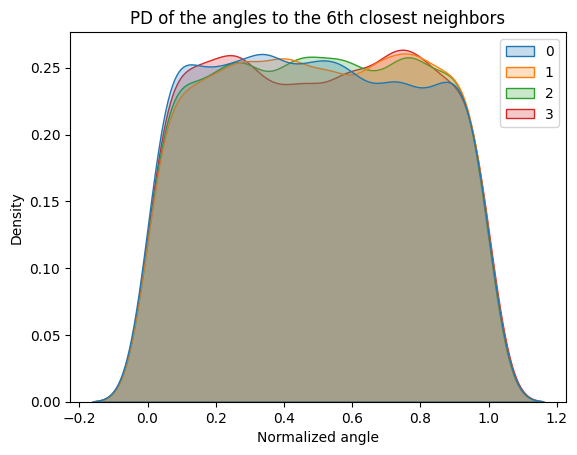

In [41]:
fig, ax = plt.subplots()

# Plot the probability distribution of the distances
sns.kdeplot(angles_normalized, shade=True, ax=ax)
# add a title
plt.title('PD of the angles to the 6th closest neighbors')
# add x and y labels
plt.xlabel('Normalized angle')
plt.show()

/tmp/ipykernel_201715/1537190276.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(distances_normalized,shade=True, ax=ax)


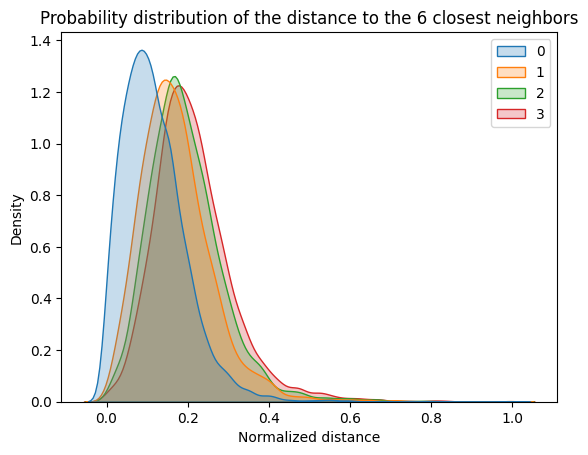

In [42]:
fig, ax = plt.subplots()
# sns.histplot(features_2_n[:, 0:6], kde=True,)
sns.kdeplot(distances_normalized,shade=True, ax=ax)

# add a title
plt.title('Probability distribution of the distance to the 6 closest neighbors')
# add x and y labels
plt.xlabel('Normalized distance')
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.histplot(features_2_n[:, 0:6], kde=True,)
# add a title
plt.title('Probability distribution of the angle to the 6 closest neighbors')
# add x and y labels
plt.xlabel('Normalized angle')
plt.show()

In [27]:
import numpy as np
import pandas as pd

# Assuming your dataset for distances is named 'distances_data' and for angles is named 'angles_data'
distances_data = distances_normalized
angles_data = angles_normalized
# Create a list to hold the transformed data
transformed_data = []

# Iterate through each row of the distances dataset
for dist_row, angle_row in zip(distances_data, angles_data):
    # For each row, iterate through the distances to the next four closer points
    for i, (distance, angle) in enumerate(zip(dist_row, angle_row)):
        # Define the class based on the index (0 = 1 closer point, 1 = 2 closer point, and so on)
        class_label = i + 1
        # Append the distance, angle, and class label to the transformed data list
        transformed_data.append([distance, angle, class_label])

# Convert the transformed data list into a pandas DataFrame
df = pd.DataFrame(transformed_data, columns=['distance', 'angle', 'class'])

# Display the first few rows of the DataFrame
print(df.head())


   distance     angle  class
0  0.013903  0.235497      1
1  0.190452  0.125854      2
2  0.228192  0.973445      3
3  0.249080  0.986066      4
4  0.254040  0.528293      5


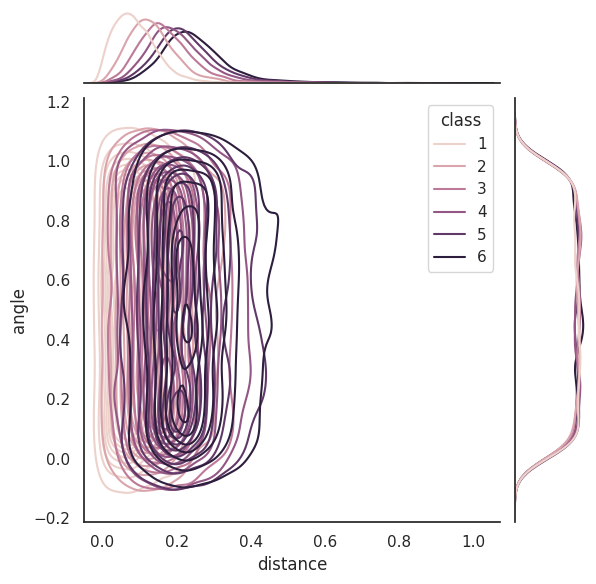

In [31]:
import seaborn as sns

# Set the color palette to diferenciate well the classes 
# sns.set_theme(
#     style="white",
#     palette="vivid",
#     )


# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df,
    x="distance", y="angle", hue="class",
    kind="kde",
)

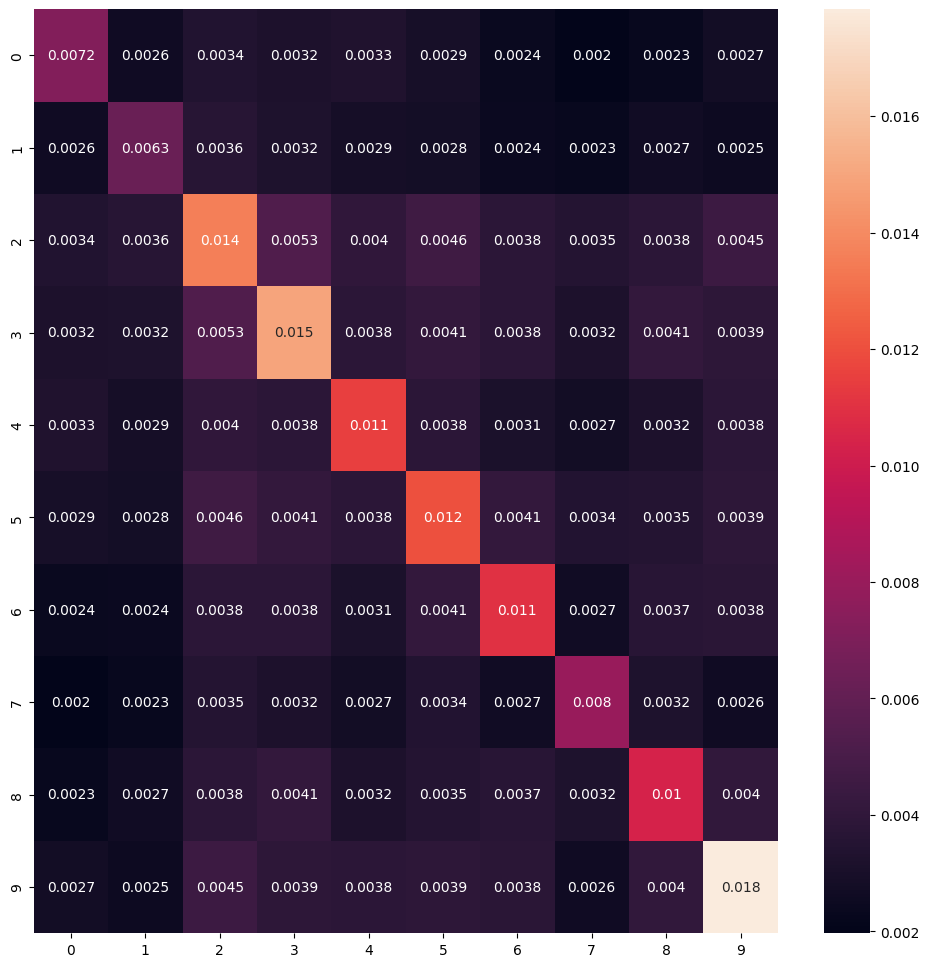

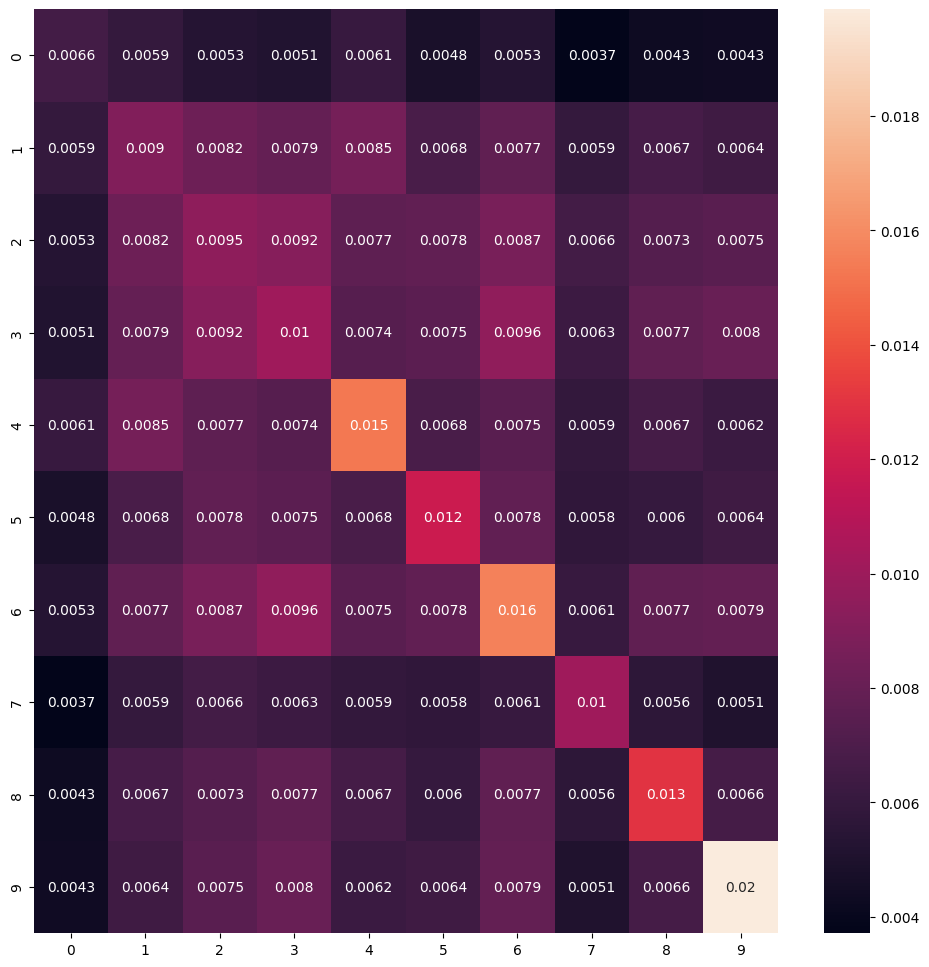

In [44]:
# Plot the covariance matrix of the features

cov_matrix = np.cov(features_1_n.T)
fig, ax = plt.subplots()
sns.heatmap(cov_matrix, annot=True, ax=ax)
#increse the size 
fig.set_size_inches(12, 12)
plt.show()

cov_matrix = np.cov(features_2_n.T)
fig, ax = plt.subplots()
sns.heatmap(cov_matrix, annot=True, ax=ax)
#increse the size 
fig.set_size_inches(12, 12)
plt.show()


Parameters with high variance can be both good and bad, depending on the context and the goals of the analysis:

    Good:
        High variance in a parameter can indicate that it contains a lot of information and exhibits significant variability across the dataset. In some cases, high variance can be desirable because it implies that the parameter captures meaningful differences or patterns in the data.
        In machine learning, high variance in model parameters can sometimes lead to better predictive performance, especially if the variance reflects important variations in the underlying data distribution.

    Bad:
        High variance can also indicate instability or sensitivity to small changes in the data. In this case, the parameter might not generalize well to new or unseen data, leading to overfitting.
        In some contexts, high variance can be undesirable because it suggests that the parameter is noisy or influenced by factors that are not relevant to the problem at hand. This can lead to less interpretable models or unreliable results.

In summary, whether high variance in parameters is good or bad depends on the specific goals of the analysis, the context of the data, and how the parameters are being used. It's important to consider factors such as model performance, generalization ability, and interpretability when evaluating the impact of parameter variance.

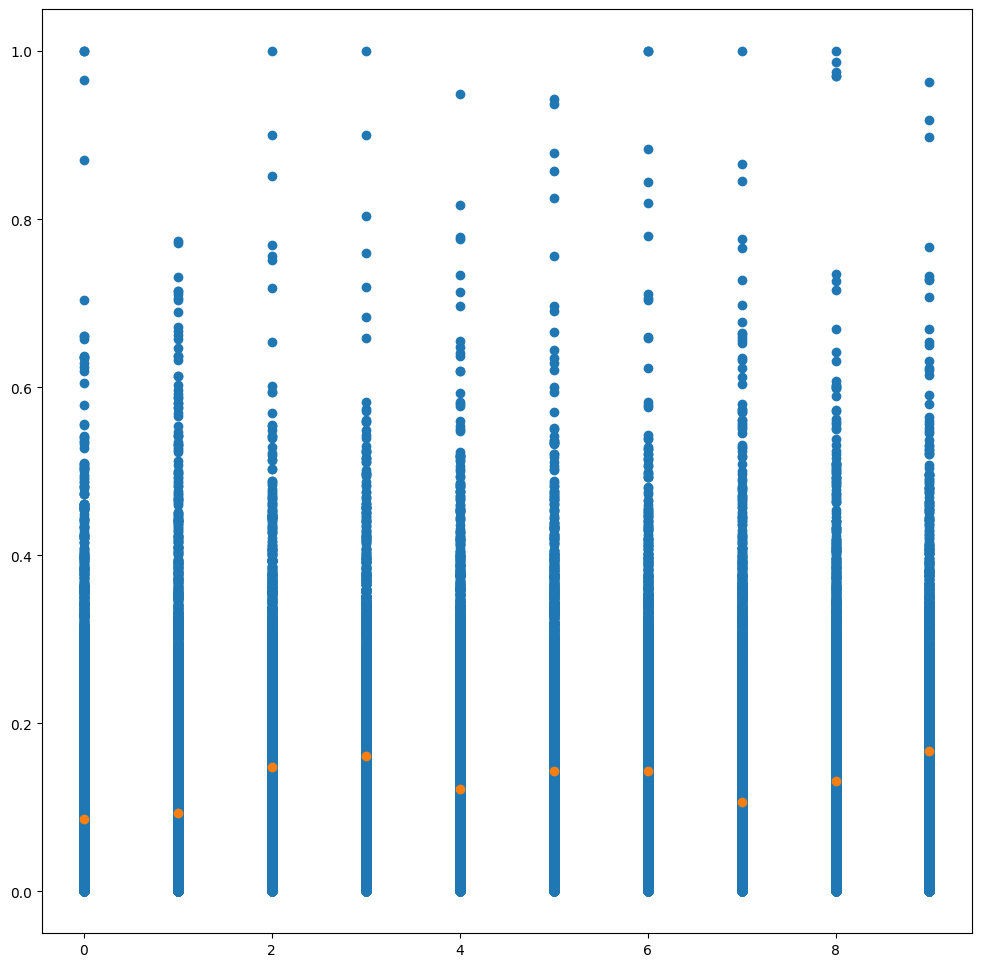

In [45]:
# plot the features

fig, ax = plt.subplots()
rang = np.zeros(features_1_n.shape) + np.arange(10)
plt.scatter(rang,features_1_n.T)
plt.scatter(rang[0],np.mean(features_1_n, axis = 0).T)
#increse the size 
fig.set_size_inches(12, 12)
plt.show()

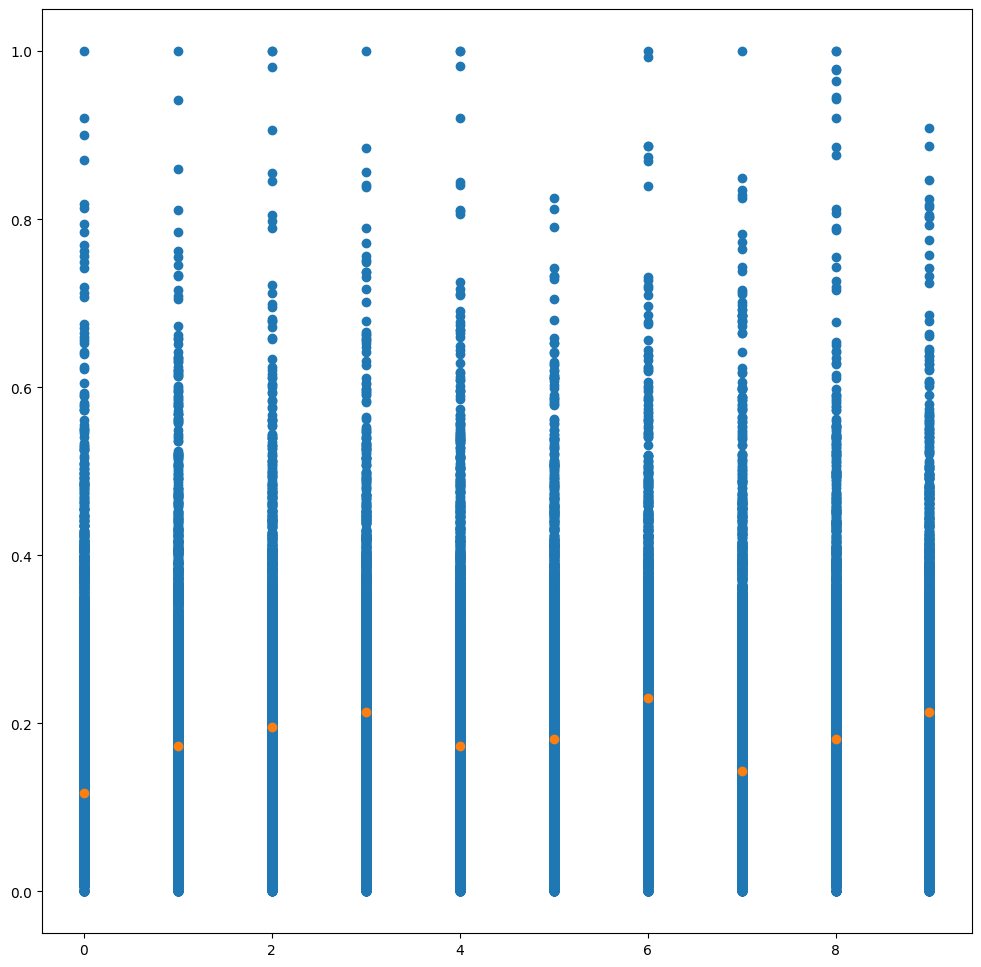

In [46]:
fig, ax = plt.subplots()
rang = np.zeros(features_2_n.shape) + np.arange(10)
plt.scatter(rang,features_2_n.T)
plt.scatter(rang[0],np.mean(features_2_n, axis = 0).T)
#increse the size 
fig.set_size_inches(12, 12)
plt.show()